### Data preparation
The terrain data was clipped to the extent of the catchment boundary using QGIS, as follows:
- Raster -> Extraction -> Clipper
- Input file -> TerrainData/terrain.tif
- Output file -> TerrainData/terrain_clipped_QGIS.tif
- NoData value -> -9999

In [8]:
import rasterio
import geopandas as gpd
import copy
import numpy as np
import matplotlib.pyplot as plt
import earthpy.spatial as es
from rasterio.plot import plotting_extent
import earthpy.plot as ep
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import matplotlib.patches as mpatches

In [37]:
def plot_spatial(axs,fp, catchment_gdf,  cbar=True, colors=None, labels=None,legend=True):
    
    # Needed for cropping
    with rasterio.open(fp) as raster_crs:
        crop_raster_profile = raster_crs.profile
        crop_bound_utm13N = catchment_gdf.to_crs(crop_raster_profile["crs"])    
    
    # Read in data
    with rasterio.open(fp) as src:
        single_cropped_image, single_cropped_meta = es.crop_image(
        src, crop_bound_utm13N)
    
    # Create the extent object
    single_crop_extent = plotting_extent(single_cropped_image[0], single_cropped_meta["transform"])
    
    # For landcover plot
    if colors!=None:
        #
        cmap = mpl.colors.ListedColormap(colors)
        # 
        if legend == True:
            patches_list = []
            for i, color in  enumerate(colors):
                patch =  mpatches.Patch(color=color, label=labels[i])
                patches_list.append(patch)  
            axs.legend(handles=patches_list, handleheight=3, handlelength=3, fontsize =5);
    
    # For terrain plot
    else:
        cmap = 'terrain'
        vmin = 0
        vmax = 250

    # 
    if colors != None:
        single_cropped_image = np.ma.masked_array(single_cropped_image[0], single_cropped_image[0] < 0.001)
        vmin = np.nanmin(single_cropped_image)
        vmax = np.nanmax(single_cropped_image)
    
    # Plot the newly cropped image
    crop_bound_utm13N.boundary.plot(ax=axs, color="black", zorder=10)
    ep.plot_bands(single_cropped_image, ax=axs, extent=single_crop_extent, cmap = cmap, 
                      vmin=vmin,vmax=vmax,cbar=cbar)
        
    # Add the watercourse track
    watercourses_clip.plot(ax=axs, linewidth=3, color = 'black')    
                
            
    axs.axis('off')

### Read in watercourses data

In [2]:
watercourses = gpd.read_file('../../../FloodModelling/ExtraData/Watercourses/WatercourseLink.shp')

## Plot terrain data for both catchments side by side

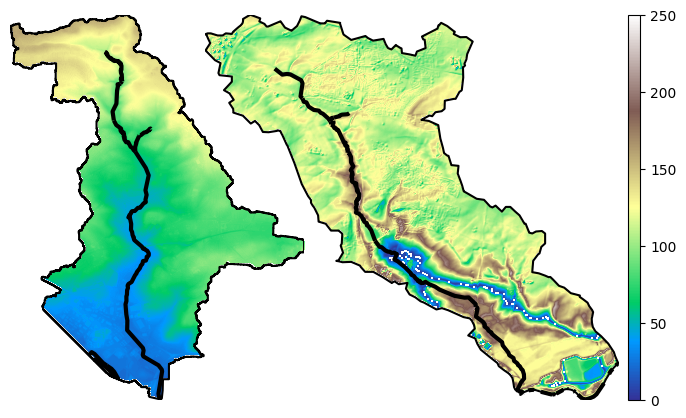

In [28]:
fig, axs = plt.subplots(ncols = 2, figsize=(12,5 ), gridspec_kw={'wspace': -0.6}, constrained_layout=False)

# Plot Wyke Beck
catchment_name  = 'WykeBeck'
model_directory = '../../../FloodModelling/{}Models/'.format(catchment_name)
catchment_gdf = gpd.read_file(model_directory + 'Model_IdealisedProfiles/WykeBeckCatchment.shp'.format(catchment_name))
watercourses_clip = gpd.clip(watercourses, catchment_gdf)
plot_spatial(axs[0], model_directory + 'TerrainData/Terrain_clipped_QGIS.tif', catchment_gdf, False) 

# Plot Lin Dyke    
catchment_name  = 'LinDyke'
model_directory = '../../../FloodModelling/{}Models/'.format(catchment_name)
catchment_gdf = gpd.read_file(model_directory + 'Model_IdealisedProfiles/CatchmentLinDyke_exported.shp'.format(catchment_name))
watercourses_clip = gpd.clip(watercourses, catchment_gdf)
plot_spatial(axs[1], model_directory + 'TerrainData/Terrain_clipped_QGIS.tif', catchment_gdf, True)  

fig.savefig("../FigsForPaper/Terrain_BothCatchments.jpg",  bbox_inches='tight')

## Plot landcover data for both catchments side by side

In [5]:
colors_dict_ld = {'clipped': ['darkslategrey', 'khaki', 'darkturquoise','darkgreen','mediumseagreen', 'thistle', 'lightgreen', 'palegreen', 'pink'],
              'urban':['darkslategrey','lightgreen'], 'water':['blue','darkslategrey']}
labels_dict_ld = {'clipped': ['SubUrban', 'Arable', 'Freshwater', 'Deciduous woodland', 'Improved grassland', 'Urban', 'Neutral grassland', 'Calcareous grassland', 'Heather grassland'],
              'urban':['Urban','Not urban'], 'water':['Water','Not water']}

colors_dict_wb = {'clipped': ['khaki', 'thistle', 'darkturquoise','darkgreen','darkslategrey', 'mediumseagreen', 'lightgreen', 'palegreen', 'pink'],
              'urban':['darkslategrey','lightgreen'], 'water':['blue','darkslategrey']}
labels_dict_wb = {'clipped': ['Arable', 'Urban', 'Freshwater', 'Deciduous woodland', 'Suburban', 'Improved Grassland', 'Neutral grassland', 'Calcareous grassland', 'Heather grassland'],
              'urban':['Urban','Not urban'], 'water':['Water','Not water']}

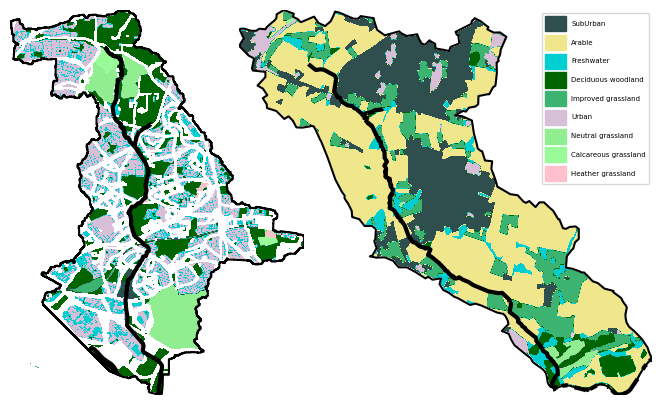

In [38]:
fig, axs = plt.subplots(ncols = 2, figsize=(12, 5), gridspec_kw={'wspace': -0.55})

catchment_name = 'WykeBeck'
model_directory = '../../../FloodModelling/{}Models/'.format(catchment_name)
catchment_gdf = gpd.read_file(model_directory + 'Model_IdealisedProfiles/WykeBeckCatchment.shp'.format(catchment_name))
watercourses_clip = gpd.clip(watercourses, catchment_gdf)
plot_spatial(axs[0], model_directory+'LandCoverData/LandCover_clipped.tif', catchment_gdf,False,  colors_dict_wb['clipped'],
          labels_dict_wb['clipped'], False) 

catchment_name = 'LinDyke'
model_directory = '../../../FloodModelling/{}Models/'.format(catchment_name)
catchment_gdf = gpd.read_file(model_directory + 'Model_IdealisedProfiles/CatchmentLinDyke_exported.shp'.format(catchment_name))
watercourses_clip = gpd.clip(watercourses, catchment_gdf)
plot_spatial(axs[1],model_directory+'LandCoverData/LandCover_clipped_QGIS.tif', catchment_gdf,False, colors_dict_ld['clipped'], 
          labels_dict_ld['clipped'], True) 

fig.savefig("../FigsForPaper/LandCover_BothCatchments.jpg",  bbox_inches='tight')

## Plot 3 landcover plots for one catchment (to check classes)

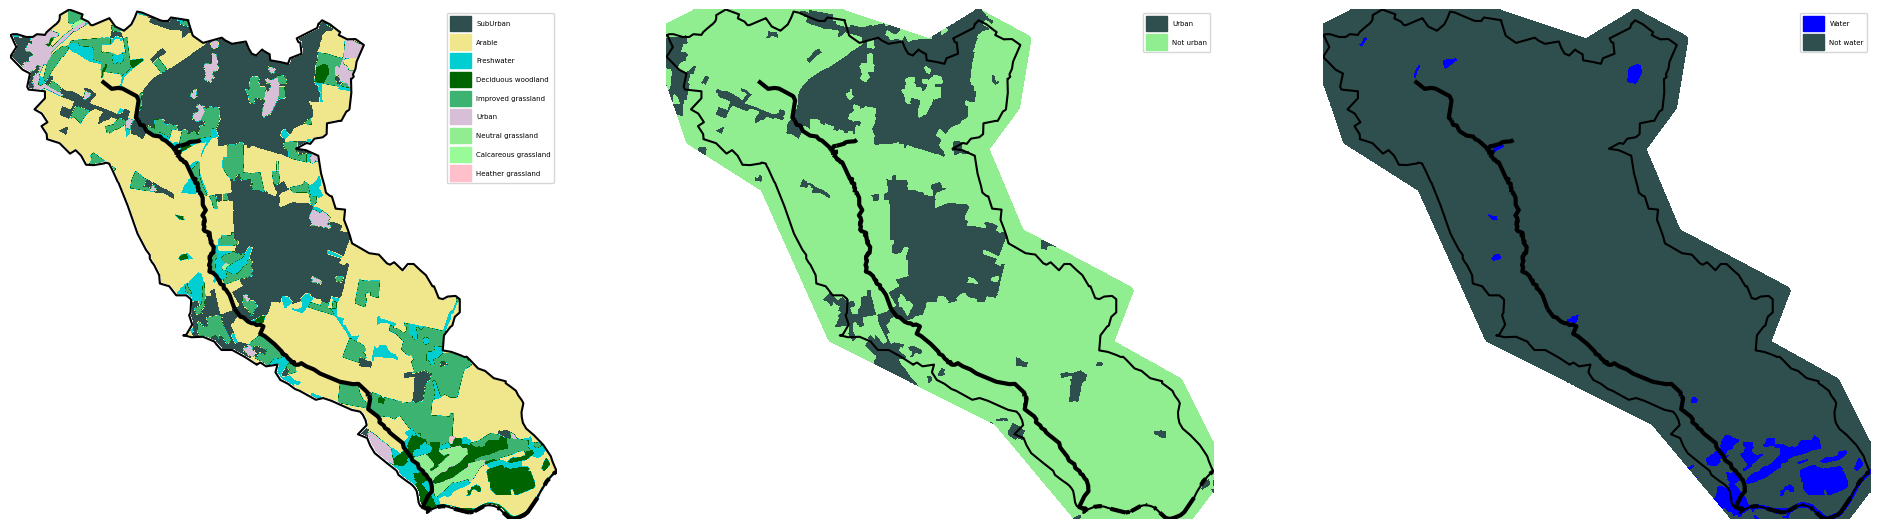

In [39]:
catchment_name  = 'LinDyke'
model_directory = '../../../FloodModelling/{}Models/'.format(catchment_name)
catchment_gdf = gpd.read_file(model_directory + 'Model_IdealisedProfiles/CatchmentLinDyke_exported.shp'.format(catchment_name))
watercourses_clip = gpd.clip(watercourses, catchment_gdf)

fig, axs = plt.subplots(ncols = 3, figsize=(24, 10))
plot_spatial(axs[0], model_directory+ 'LandCoverData/LandCover_clipped_QGIS.tif', catchment_gdf, False, colors_dict_ld['clipped'], labels_dict_ld['clipped'])    
plot_spatial(axs[1],  model_directory+'LandCoverData/LandCover_urban_classification.tif', catchment_gdf,False,  colors_dict_ld['urban'], labels_dict_ld['urban'])  
plot_spatial(axs[2],  model_directory+'LandCoverData/LandCover_water_classification.tif',catchment_gdf,False,   colors_dict_ld['water'], labels_dict_ld['water'])    

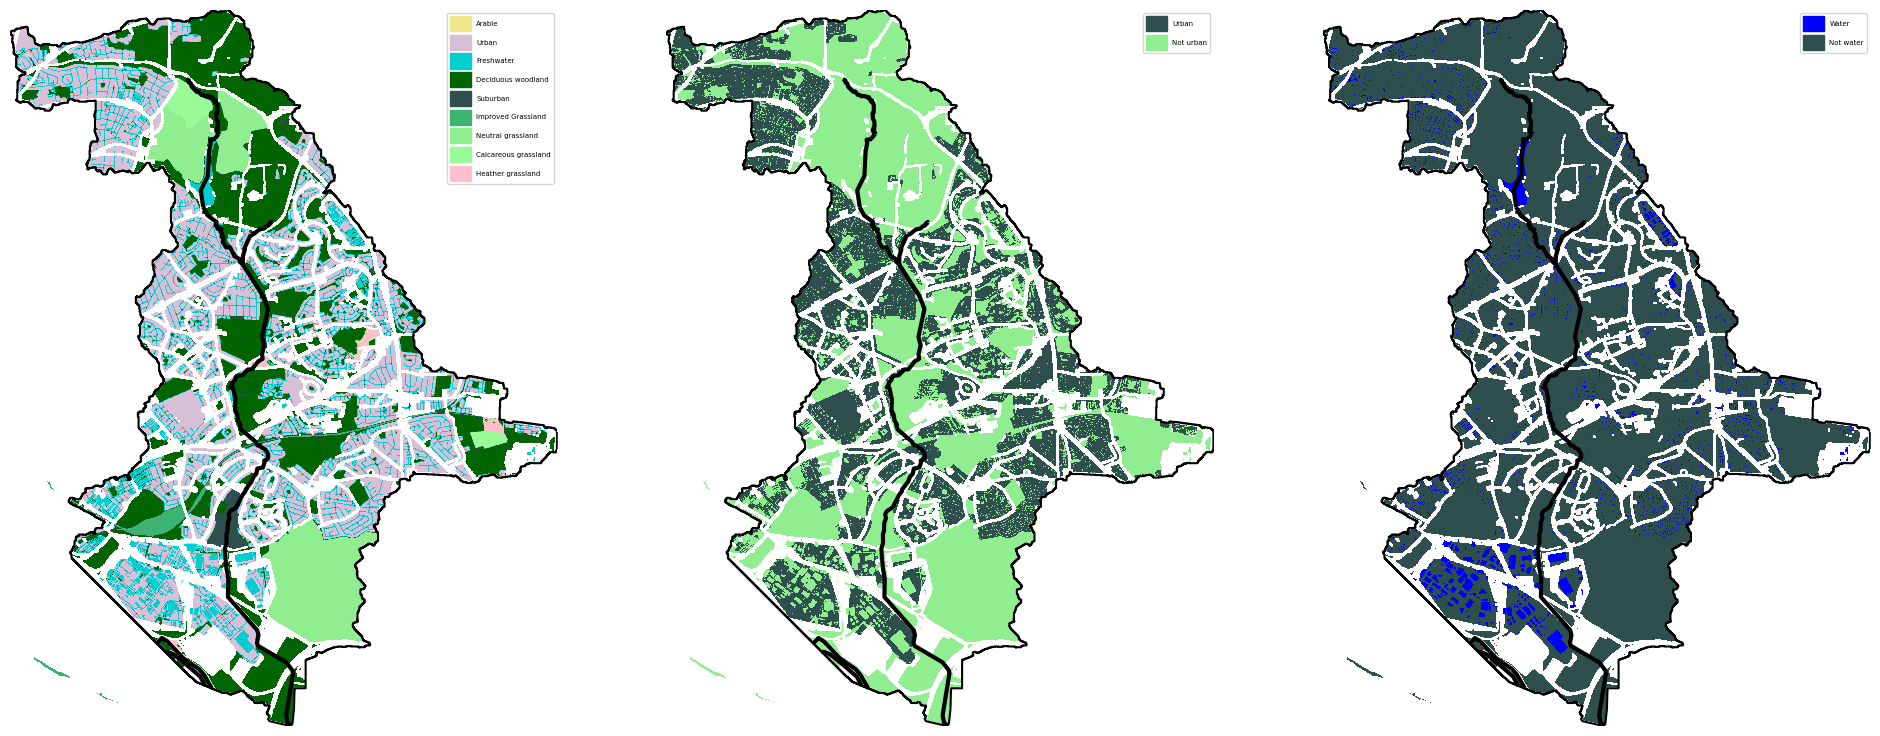

In [40]:
catchment_name  = 'WykeBeck'
model_directory = '../../../FloodModelling/{}Models/'.format(catchment_name)
catchment_gdf = gpd.read_file(model_directory + 'Model_IdealisedProfiles/WykeBeckCatchment.shp'.format(catchment_name))
watercourses_clip = gpd.clip(watercourses, catchment_gdf)

fig, axs = plt.subplots(ncols = 3, figsize=(24, 10))
plot_spatial(axs[0], model_directory+ 'LandCoverData/LandCover_clipped.tif', catchment_gdf,False, colors_dict_wb['clipped'], labels_dict_wb['clipped'])    
plot_spatial(axs[1],  model_directory+'LandCoverData/LandCover_urban_classification.tif', catchment_gdf,False, colors_dict_wb['urban'], labels_dict_wb['urban'])  
plot_spatial(axs[2],  model_directory+'LandCoverData/LandCover_water_classification.tif',catchment_gdf,False,  colors_dict_wb['water'], labels_dict_wb['water'])        

### Find average elevation in each catchment
Old section looking at subcatchment areas.  
Look at GitHub if want to return to this code.

In [32]:
# import pandas as pd
# import rioxarray as rxr

In [30]:
# main_df=pd.DataFrame()
# raster = rxr.open_rasterio(model_directory + 'TerrainData/Terrain_clipped_QGIS.tif', masked=True).squeeze()
# for region_name in ['LinDyke', 'Kippax', 'Garforth', 'Kippax_West', 'Garforth_East', 'Garforth_West', 'South_Catchment', 
#                     'TB_South', 'TB_North']:
#     # Get region boundary
#     region_boundary = boundaries_gpd_dict[region_name]
        
#     # Trim terrain data
#     raster_clipped = raster.rio.clip(region_boundary.geometry.apply(mapping),region_boundary.crs)
    
#     # Add to 
#     df= pd.DataFrame({'mean1':np.nanmean(raster_clipped[1].data), "max1":np.nanmax(raster_clipped[1].data), 
#                       'min1':np.nanmin(raster_clipped[1].data)}, index=[region_name])
#     main_df=pd.concat([df, main_df],axis=0)

In [31]:
# main_df.sort_values(by='mean1', ascending=False)

## Interactive landcover class plotting

In [16]:
import folium
subcatchments=False
import sys
sys.path.append("../ProcessModelResults/")
from my_functions import *

In [18]:
# # Set up figure
# f = folium.Figure(width=1000, height=1000)

# # Create base map - location figures were from clat, clon, but wanted to create map before loop
# mapa = folium.Map(location=[53.768306874761016, -1.3756056884868098],zoom_start=12).add_to(f)
# folium.TileLayer(
#     tiles = 'https://basemap.nationalmap.gov/arcgis/rest/services/USGSTopo/MapServer/tile/{z}/{y}/{x}',
#     attr="No Base Map",
#     name="No Base Map",
#     show=True
# ).add_to(mapa)

# if subcatchments == True:
#     for subcatchment in ['LinDyke', 'Garforth_East', 'Garforth_West']:
#         # Catchment boundary
#         catchment_boundary_feature_group = FeatureGroup(name=subcatchment)
#         catchment_boundary_feature_group.add_child(folium.GeoJson(data=boundaries_gpd_dict[subcatchment]["geometry"],
#             style_function=lambda x,  fillColor='#00000000', color='Black': { "fillColor": '#00000000',"color": 'Black',}))
#         # Add to map
#         mapa.add_child(catchment_boundary_feature_group)

# # Add landcover data
# landcover_fps = [model_directory + 'LandCoverData/LandCover_clipped.tif',
#                  model_directory + 'LandCoverData/LandCover_water_classification.tif']
# names = ['Original', 'Classified']
# for number, landcover_fp in enumerate(landcover_fps):
#     xarray_dataarray = prep_for_folium_plotting(landcover_fp)
#     # Get coordinates needed in plotting
#     clat, clon = xarray_dataarray.y.values.mean(), xarray_dataarray.x.values.mean()
#     mlat, mlon = xarray_dataarray.y.values.min(), xarray_dataarray.x.values.min()
#     xlat, xlon = xarray_dataarray.y.values.max(), xarray_dataarray.x.values.max()
#     # Apply colormap
#     data  = ma.masked_invalid(xarray_dataarray.values)
#     colored_data = colorize(data.data, cmap='terrain')
    
#     # Add to map
#     feature_group1 = FeatureGroup(name=names[number])
#     feature_group1.add_child(folium.raster_layers.ImageOverlay(colored_data, [[mlat, mlon], [xlat, xlon]],
#                               opacity=0.8,interactive=True, popup=names[number]))
#     mapa.add_child(feature_group1)

# # Add layers to map
# mapa.add_child(LayerControl("topright", collapsed = False))
# display(mapa)